<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/xai_lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import Adam,SGD
from skimage.segmentation import mark_boundaries
from xml.etree import ElementTree

Model 23


In [0]:
saved_model = load_model('/content/drive/My Drive/xai_model/model_25.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
saved_model.layers[0].input_shape

(None, None, None, 3)

In [0]:
#saved_model.summary()

In [0]:
annotation = '/content/drive/My Drive/NEU-DET/ANNOTATIONS/scratches_94.xml'
image_path="/content/drive/My Drive/NEU surface defect database - test split/Test/Sc/Sc_94.bmp"

In [0]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

[5]
[[1.6268704e-04 2.0555675e-05 6.9452727e-07 1.8824422e-03 1.4046016e-05
  9.9791962e-01]]
Scratches


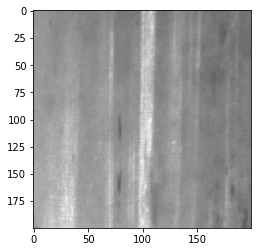

In [0]:
img = image.load_img(image_path, target_size=(200,200))
b_img = cv2.imread(image_path)
plt.imshow(img)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
result = saved_model.predict(img)

prediction = result.argmax(axis=1)
print(prediction)
output = labels[int(prediction)]

print(result)
print(output)

In [0]:
def extract_boxes(filename):
	tree = ElementTree.parse(filename)
	root = tree.getroot()	
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	return boxes 

boxes = extract_boxes(annotation)

print(boxes)


[[93, 1, 115, 199], [22, 97, 42, 199], [120, 35, 145, 173], [71, 95, 85, 121], [72, 144, 84, 172]]


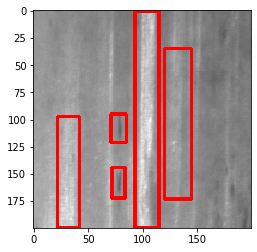

In [0]:
for i in range(len(boxes)):
  pt1 = boxes[i][0], boxes[i][1]
  pt2 = boxes[i][2], boxes[i][3]
  #print(pt1, pt2)
  cv2.rectangle(b_img, pt1, pt2, (255, 0, 0), 2)
  plt.imshow(b_img)

In [0]:
!pip install lime

In [0]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
explainer = lime_image.LimeImageExplainer()

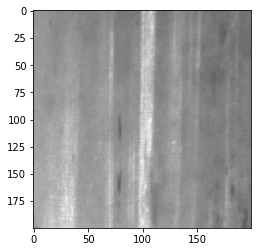

In [0]:
test_img = image.load_img(image_path)
plt.imshow(test_img)

test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)
test_img = preprocess_input(test_img)

In [0]:
%%time
# Hide color is the color for a superpixel turned OFF. 
# Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(test_img[0], saved_model.predict, top_labels=6, hide_color=0)

CPU times: user 5.41 s, sys: 1.37 s, total: 6.78 s
Wall time: 6.51 s


In [0]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}
print("Predictions:")
for i in range(len(explanation.top_labels)):
  rank = explanation.top_labels[i]
  print(i,':',labels[rank])
  

Predictions:
0 : Scratches
1 : Patches
2 : Crazing
3 : Inclusion
4 : Rolled-in Scale
5 : Pitted Surface


labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

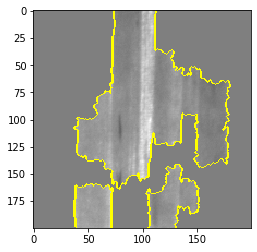

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

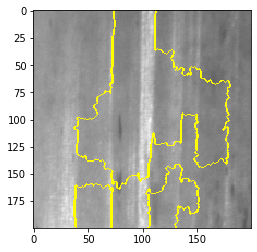

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
#plt.savefig('/content/drive/My Drive/XAI_results/LIME_Sc_15_2.jpg')

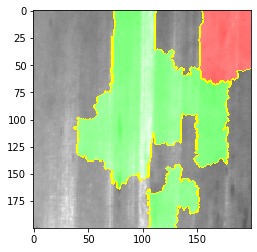

In [0]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
#plt.savefig('/content/drive/My Drive/XAI_results/LIME_Sc_15.jpg')

In [0]:
#temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, hide_rest=False, min_weight=0.5)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

In [0]:
test_generator = test_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Test2',
                                                  target_size=(200,200),     
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle = False)

Found 1 images belonging to 1 classes.


In [0]:
step_size_test = test_generator.n//test_generator.batch_size
print(step_size_test)

test_generator.reset()

1


In [0]:
predIndxs = saved_model.predict_generator(test_generator, steps = step_size_test, verbose=1 )

1/1 [==============================] - 1s 628ms/step


In [0]:
predIndxs

array([[1.5886339e-07, 4.4278686e-08, 6.0563586e-08, 1.7022429e-06,
        2.0976826e-07, 9.9999785e-01]], dtype=float32)

In [0]:
predIndx = np.argmax(predIndxs, axis=1)
print(predIndx)

[5]


In [0]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

In [0]:
output = labels[int(predIndx)]

print(output)

Scratches


In [0]:
%%time
# Hide color is the color for a superpixel turned OFF. 
# Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(test_img[0], predIndxs, top_labels=6, hide_color=0)